In [1]:
!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 455.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [16]:
from pycaret.clustering import *
from pycaret.clustering import setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Se levanta el dataset llamado reporte
df = pd.read_excel('/content/drive/My Drive/TP_Maestria/Fundamentos_Aprendizaje/Clustering/Reporte.xlsx')
df.head()

,Fecha de venta,Canal de Venta,Cliente,Provincia,Cantidad vendida,Precio unitario dolar,Precio de venta,Número de publicación,Categoría de la publicación
0,2024-01-30,Mercado Libre,AILENGUADALUPEMARTORELLA,Neuquén,6,4.088624,24.531745,MLA1401793983,"Hogar, Muebles y Jardín > Cuidado del Hogar y ..."
1,2024-01-30,Mercado Libre,ROSSOCRISTIAN20231018184201,CIUDAD AUTONOMA BUENOS AIRES,8,4.638652,37.109214,MLA1625102786,"Hogar, Muebles y Jardín > Cuidado del Hogar y ..."
2,2024-01-30,Mercado Libre,SILVYN2011,Buenos Aires,1,4.088624,4.088624,MLA1401793983,"Hogar, Muebles y Jardín > Cuidado del Hogar y ..."
3,2024-01-30,Mercado Libre,J4NU$,Capital Federal,10,4.088624,40.886242,MLA1401793983,"Hogar, Muebles y Jardín > Cuidado del Hogar y ..."
4,2024-01-30,Mercado Shops,ALEXISMARILINREINERT,Misiones,1,2.315452,2.315452,MLA1521716292,"Hogar, Muebles y Jardín > Bazar y Cocina > Vaj..."


Ya se realizó el EDA en otro código, se redujeron las variables y se  reemplazoron de valores nulos.

In [6]:
df.shape

(28133, 9)

In [7]:
#Eliminar columnas de manera que queden sólo las esenciales para el analisis de clientes
data = df.drop(['Canal de Venta', 'Precio unitario dolar','Número de publicación', 'Categoría de la publicación'], axis=1)

In [8]:
#Renombrar las columnas
data = data.rename(columns={'Fecha de venta':'Fecha','Cantidad vendida':'Cantidad_productos', 'Precio de venta': 'Monto_ventas'})
data.head()

,Fecha,Cliente,Provincia,Cantidad_productos,Monto_ventas
0,2024-01-30,AILENGUADALUPEMARTORELLA,Neuquén,6,24.531745
1,2024-01-30,ROSSOCRISTIAN20231018184201,CIUDAD AUTONOMA BUENOS AIRES,8,37.109214
2,2024-01-30,SILVYN2011,Buenos Aires,1,4.088624
3,2024-01-30,J4NU$,Capital Federal,10,40.886242
4,2024-01-30,ALEXISMARILINREINERT,Misiones,1,2.315452


##**1. Modelo K-means**

Adecuado para dataset grandes, grupos  esféricos y datos bien separados. Es rápido y eficiente, pero requiere especificar la cantidad de grupos de antemano, luego se puede ajustar con el método del Codo de Jambú

##**a) Primer análisis incluyendo las "Provincias" como variable**

In [9]:
# Se genera un nuevo dataser con la cantidad real de clinetes y se agreagan las siguientes variables: la fecha de la última compra, la suma d ela cantidad de productos y la suma del monto de ventas
data_grupo = data.groupby(['Cliente','Provincia']).agg({'Fecha':'max','Cantidad_productos':'sum', 'Monto_ventas': 'sum'}).reset_index()

# Se visualizan las primeras filas del dataset agrupado
print(data_grupo.head (50))


                      Cliente        Provincia      Fecha  Cantidad_productos  \
0                     #ERROR!  Capital Federal 2022-08-02                   8   
1                 *MARIANITA*  Capital Federal 2024-08-29                   3   
2             -CABEZADENOVIA-  Capital Federal 2022-10-10                   1   
3                      .AGOS.     Buenos Aires 2024-03-16                   3   
4                .YASTERHAUS.     Buenos Aires 2024-07-18                   2   
5                     0050CMX  Capital Federal 2024-08-11                   2   
6                  0904MATPAB     Buenos Aires 2024-07-16                   7   
7                  120DOLORES  Capital Federal 2023-05-06                   1   
8                    12SILLAS     Buenos Aires 2023-04-12                  11   
9                  1509HELENA  Capital Federal 2023-07-06                   1   
10                 1998MATIAS  Capital Federal 2023-07-08                   1   
11                  2000MARI

In [10]:
#Cantidad de clientes
data_grupo.shape

(12035, 5)

In [ ]:
# Inicia el setup de clustering se deja afuera la variable 'Clientes'
setup(data_grupo, normalize=True, ignore_features=['Cliente'], session_id=123)

# Entrenar modelo de clustering usando Kmeans, se requiere definir un numero de cluster, luego se puede ajustar
kmeans = create_model('kmeans', num_clusters=5)


,Description,Value
0,Session id,123
1,Original data shape,"(12035, 5)"
2,Transformed data shape,"(12035, 48)"
3,Ignore features,1
4,Numeric features,2
5,Date features,1
6,Categorical features,1
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mean


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0938,316.8419,1.9722,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

**Métricas de validación**

Índice de Silhouette: mide qué tan bien definidos están los clusters, o sea mide la similitud de cada punto con su propio grupo en comparación con otros grupos. Sus valores van desde -1 (mal agrupadas) a 1 (bien agrupadas). En este caso el valor es malo.

Índice de Calinski-Harabasz: evalúa la relación de la varianza entre los clusters y la varianza dentro de los clusters, o sea mide qué tan estrechamente relacionados están los elementos de un grupo y qué tan distinto es un grupo de otros grupos. Cuanto mayor sea este valor, mejor definidos están los clusters.

Índice de Davies-Bouldin: evalúa la similitud entre clusters, midiendo la relación de similitud promedio de cada grupo con el grupo más similar a él. Cuanto menor sea este valor, mejor es la separación entre clusters.

Las métricas Homogeneity, Rand Index, y Completeness no son relevantes en este caso porque se está usando un algoritmo de clustering no supervisado, o sea con etiquetas no conocidas.


**Método del codo**


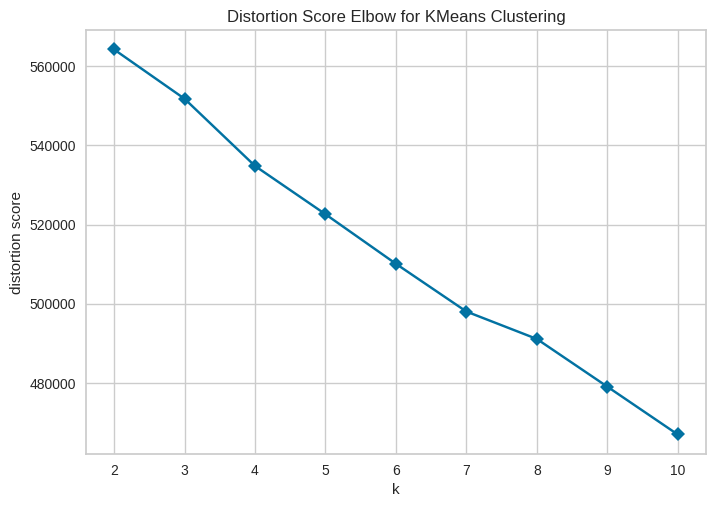

In [ ]:
# Gráfico de codos
plot_model(kmeans, plot='elbow')


No se ve un corte en la gráfica del codo de Jambú por lo que no habría una cantidad optima de clusters.

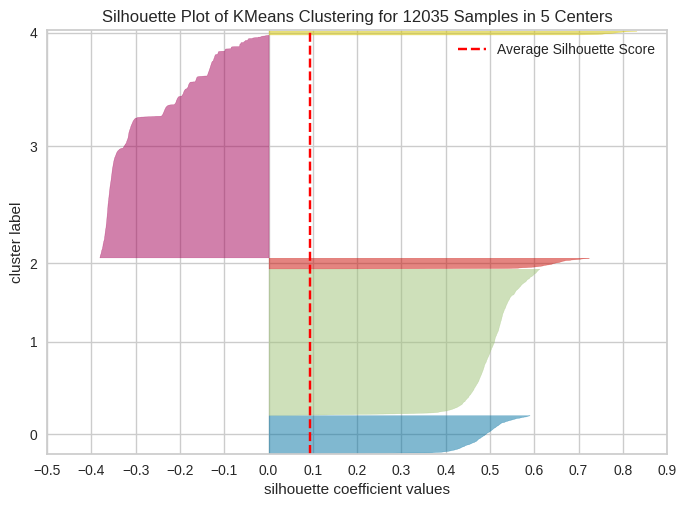

In [ ]:
#La linea de puntos roja me indica el indice de silhouette
plot_model(kmeans, plot = 'silhouette')

In [ ]:
# Entreno para probar un modelo con 10 clusters
kmeans_10 = create_model('kmeans', num_clusters=10)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1704,316.6118,1.5082,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Este modelo no es adecuado. El problema parece estar en la variable 'provincia', ya que, al ser de texto libre, hay varias formas de escribir las misma provincias, lo que genera demasiadas opciones. Sería mejor eliminarla

##**b) Segundo análisis, no incluyendo 'Provincia' como variable**

In [11]:
#Saco la variable provincia
setup(data_grupo, normalize=True, ignore_features=['Cliente', 'Provincia'], session_id=123)

# Entrenar modelo de clustering
kmeans_b = create_model('kmeans', num_clusters=4)


,Description,Value
0,Session id,123
1,Original data shape,"(12035, 5)"
2,Transformed data shape,"(12035, 5)"
3,Ignore features,2
4,Numeric features,2
5,Date features,1
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2774,4612.1609,1.1119,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

**Métricas de validación**

Mejoraron respecto al primer análisis. Buscaremos el valor optimo de clusters

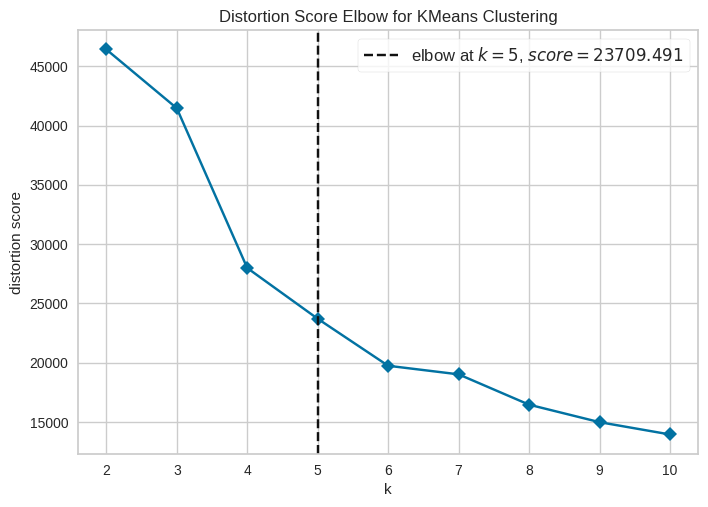

In [12]:
# Gráfico de codos
plot_model(kmeans_b, plot='elbow')

In [13]:
kmeans_b5 = create_model('kmeans', num_clusters=5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2764,4625.5747,1.1770,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
kmeans_b6 = create_model('kmeans', num_clusters=6)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2825,4926.0650,1.0641,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

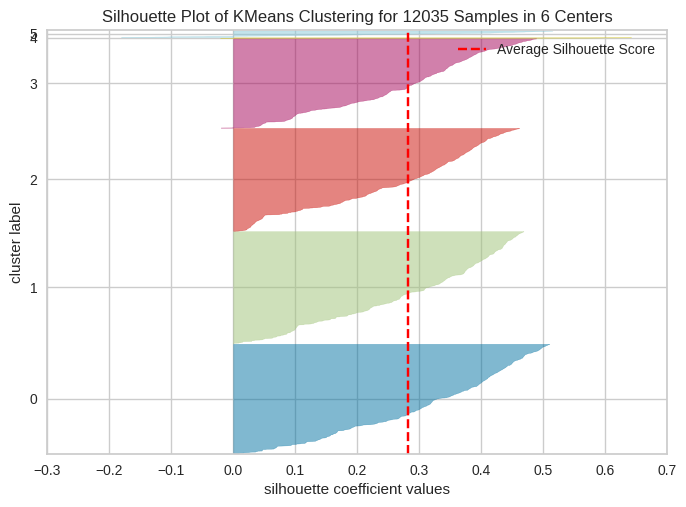

In [ ]:
plot_model(kmeans_b6, plot = 'silhouette')

In [ ]:
kmeans_b7 = create_model('kmeans', num_clusters=7)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2772,4337.1061,1.0854,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Tomamos n=6 como valor óptimo de clusters, es el que da las mejores métricas.

In [ ]:
# Asignar las etiquetas de cluster a cada fila
clustered_data = assign_model(kmeans_b6)

print(clustered_data.head(50))

        Fecha  Cantidad_productos  Monto_ventas    Cluster
0  2022-08-02                   8     16.591118  Cluster 0
1  2024-08-29                   3     15.820312  Cluster 3
2  2022-10-10                   1      6.760200  Cluster 0
3  2024-03-16                   3     23.246948  Cluster 3
4  2024-07-18                   2      9.998872  Cluster 3
5  2024-08-11                   2      8.272604  Cluster 2
6  2024-07-16                   7     29.782055  Cluster 3
7  2023-05-06                   1      4.694909  Cluster 2
8  2023-04-12                  11     52.575260  Cluster 2
9  2023-07-06                   1      4.022329  Cluster 2
10 2023-07-08                   1      4.022329  Cluster 2
11 2023-04-11                   2      8.325472  Cluster 2
12 2023-05-23                   6     20.802094  Cluster 3
13 2023-07-06                   1      1.370051  Cluster 2
14 2023-09-14                  45    193.677170  Cluster 0
15 2023-12-29                   2      9.302759  Cluster

In [ ]:
#Plot del modelo usanddo PCA
plot_model(kmeans_b6, plot='cluster')

Dado que es difícil interpretar el gráfico de PCA y considerando que son tres las variables, se realiza un gráfico 3D

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Asignar etiquetas de cluster
clustered_data = assign_model(kmeans_b6)

In [ ]:
# Verifica los tipos de datos en tu dataset
print(clustered_data.dtypes)


Fecha                 datetime64[ns]
Cantidad_productos             int32
Monto_ventas                 float32
Cluster                       object
dtype: object


In [ ]:
# Se modifica el tipo de dato 'Fecha' para poder hacer el grafico en 3D y Cluster
clustered_data['Fecha'] = pd.to_datetime(clustered_data['Fecha']) - pd.Timestamp('2020-01-01') # convert the column to Timestamp objects before subtracting
clustered_data['Fecha'] = clustered_data['Fecha'].dt.days

print(clustered_data.dtypes)


Fecha                   int64
Cantidad_productos      int32
Monto_ventas          float32
Cluster                object
dtype: object


In [ ]:
# Eliminar el texto 'Cluster ' y convertir la columna a enteros
clustered_data['Cluster'] = clustered_data['Cluster'].str.replace('Cluster ', '').astype(int)


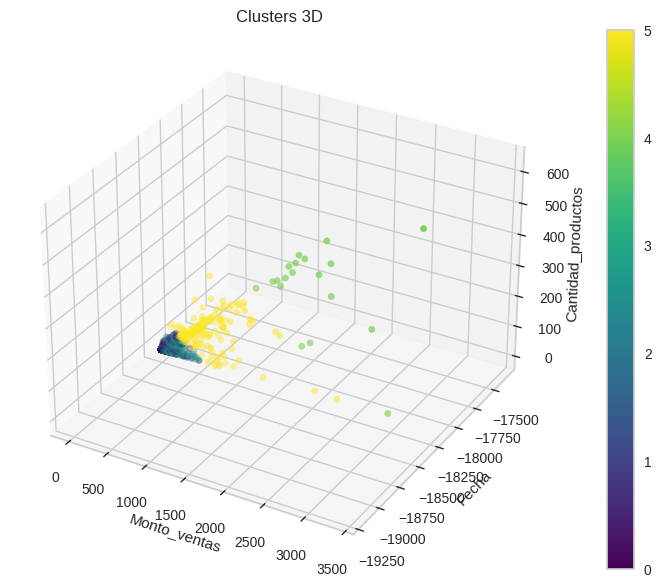

In [ ]:
#Grafico 3D
x = clustered_data['Monto_ventas']
y = clustered_data['Fecha']
z = clustered_data['Cantidad_productos']
clusters = clustered_data['Cluster']

# Crear el gráfico 3D
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=clusters, cmap='viridis')

# Añadir etiquetas y título
ax.set_xlabel('Monto_ventas')
ax.set_ylabel('Fecha')
ax.set_zlabel('Cantidad_productos')
ax.set_title('Clusters 3D')

# Añadir la barra de colores
plt.colorbar(sc)
plt.show()


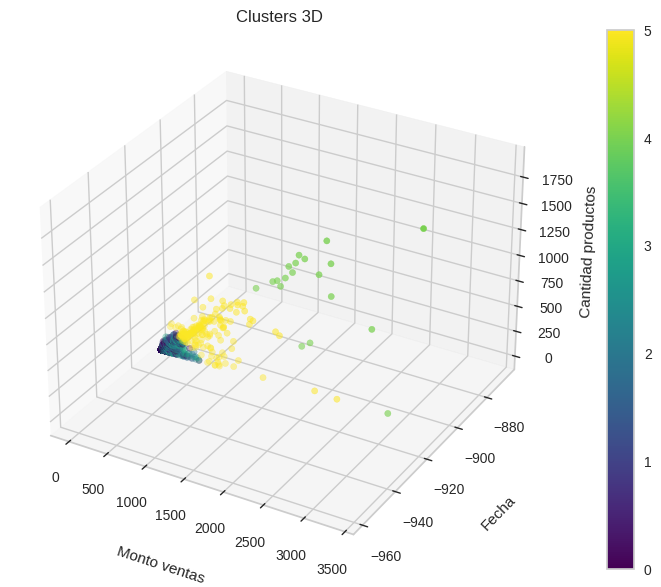

In [ ]:
# Escalar los valores de los ejes para que se vea mejor el grafico
y_scaled = clustered_data['Fecha'] * 0.05  # Concentrar eje Y
z_scaled = clustered_data['Cantidad_productos'] * 3  # Dilatar eje Z

# Crear el gráfico 3D
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y_scaled, z_scaled, c=clusters, cmap='viridis')

# Añadir etiquetas y título
ax.set_xlabel('Monto ventas',labelpad=20)
ax.set_ylabel('Fecha',labelpad=20)
ax.set_zlabel('Cantidad productos',labelpad=10)
ax.set_title('Clusters 3D')

# Añadir la barra de colores
plt.colorbar(sc)
plt.show()

In [ ]:
print(clustered_data.head(10))

   Fecha  Cantidad_productos  Monto_ventas  Cluster
0 -18262                   8     16.591118        0
1 -18262                   3     15.820312        3
2 -18262                   1      6.760200        0
3 -18262                   3     23.246948        3
4 -18262                   2      9.998872        3
5 -18262                   2      8.272604        2
6 -18262                   7     29.782055        3
7 -18262                   1      4.694909        2
8 -18262                  11     52.575260        2
9 -18262                   1      4.022329        2


In [ ]:
clustered_data.shape

(12035, 4)

In [ ]:
print(data_grupo.head(10))


           Cliente        Provincia      Fecha  Cantidad_productos  \
0          #ERROR!  Capital Federal 2022-08-02                   8   
1      *MARIANITA*  Capital Federal 2024-08-29                   3   
2  -CABEZADENOVIA-  Capital Federal 2022-10-10                   1   
3           .AGOS.     Buenos Aires 2024-03-16                   3   
4     .YASTERHAUS.     Buenos Aires 2024-07-18                   2   
5          0050CMX  Capital Federal 2024-08-11                   2   
6       0904MATPAB     Buenos Aires 2024-07-16                   7   
7       120DOLORES  Capital Federal 2023-05-06                   1   
8         12SILLAS     Buenos Aires 2023-04-12                  11   
9       1509HELENA  Capital Federal 2023-07-06                   1   

   Monto_ventas  
0     16.591118  
1     15.820312  
2      6.760200  
3     23.246948  
4      9.998872  
5      8.272604  
6     29.782055  
7      4.694909  
8     52.575259  
9      4.022329  


In [ ]:
# Agregar la columna 'cluster' de clustered_data a data_grupo
data_grupo['Cluster'] = clustered_data['Cluster']
print(data_grupo.head(10))

           Cliente        Provincia      Fecha  Cantidad_productos  \
0          #ERROR!  Capital Federal 2022-08-02                   8   
1      *MARIANITA*  Capital Federal 2024-08-29                   3   
2  -CABEZADENOVIA-  Capital Federal 2022-10-10                   1   
3           .AGOS.     Buenos Aires 2024-03-16                   3   
4     .YASTERHAUS.     Buenos Aires 2024-07-18                   2   
5          0050CMX  Capital Federal 2024-08-11                   2   
6       0904MATPAB     Buenos Aires 2024-07-16                   7   
7       120DOLORES  Capital Federal 2023-05-06                   1   
8         12SILLAS     Buenos Aires 2023-04-12                  11   
9       1509HELENA  Capital Federal 2023-07-06                   1   

   Monto_ventas  Cluster  
0     16.591118        0  
1     15.820312        3  
2      6.760200        0  
3     23.246948        3  
4      9.998872        3  
5      8.272604        2  
6     29.782055        3  
7      4.6949

In [ ]:
# Descargar data_grupo a un archivo Excel
data_grupo.to_excel("Grupos_clientes.xlsx", index=False)

**Guardado del modelo**




In [21]:
save_model(kmeans_b6, '/content/drive/My Drive/TP_Maestria/Fundamentos_Aprendizaje/Clustering/final_Kmeans_b6')


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['Fecha'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['Cantidad_productos',
                                              'Monto_ventas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('trained_model', KMeans(n_clusters=6, random_state=123))]),
 '/content/drive/My Drive/TP_Maestria/Fundamentos_Aprendizaje/Clustering/final_Kmeans_b6.pkl')

##**Análisis de los clusters**

In [ ]:
import seaborn as sns

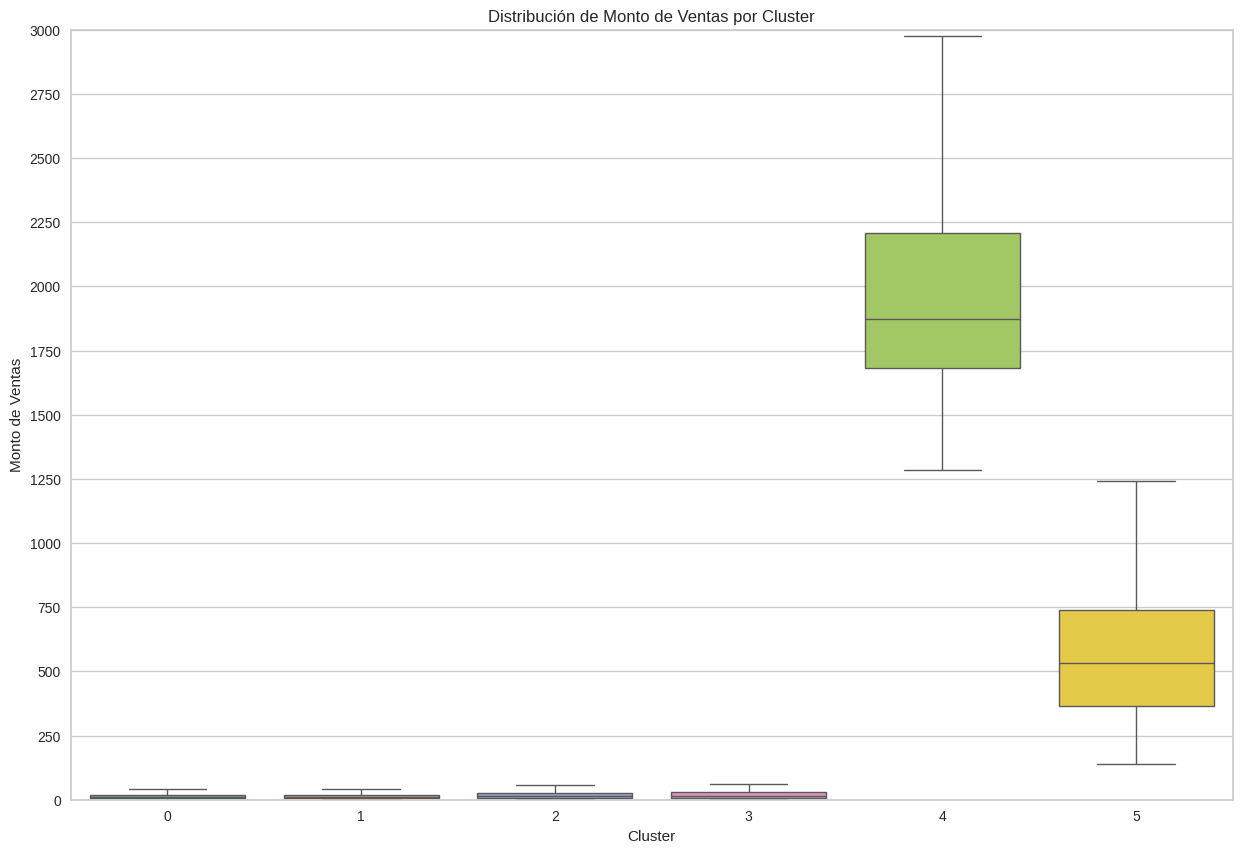

In [ ]:
# Gráfico boxplot para la variable Monto de venta
palette = sns.color_palette("Set2")
plt.figure(figsize=(15, 10))
sns.boxplot(x='Cluster', y='Monto_ventas', data=data_grupo, palette=palette, showfliers=False)
plt.ylim(0, 3000)
plt.yticks(ticks=np.arange(0, 3001, 250))

plt.title('Distribución de Monto de Ventas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monto de Ventas')

# Mostrar el gráfico
plt.show()


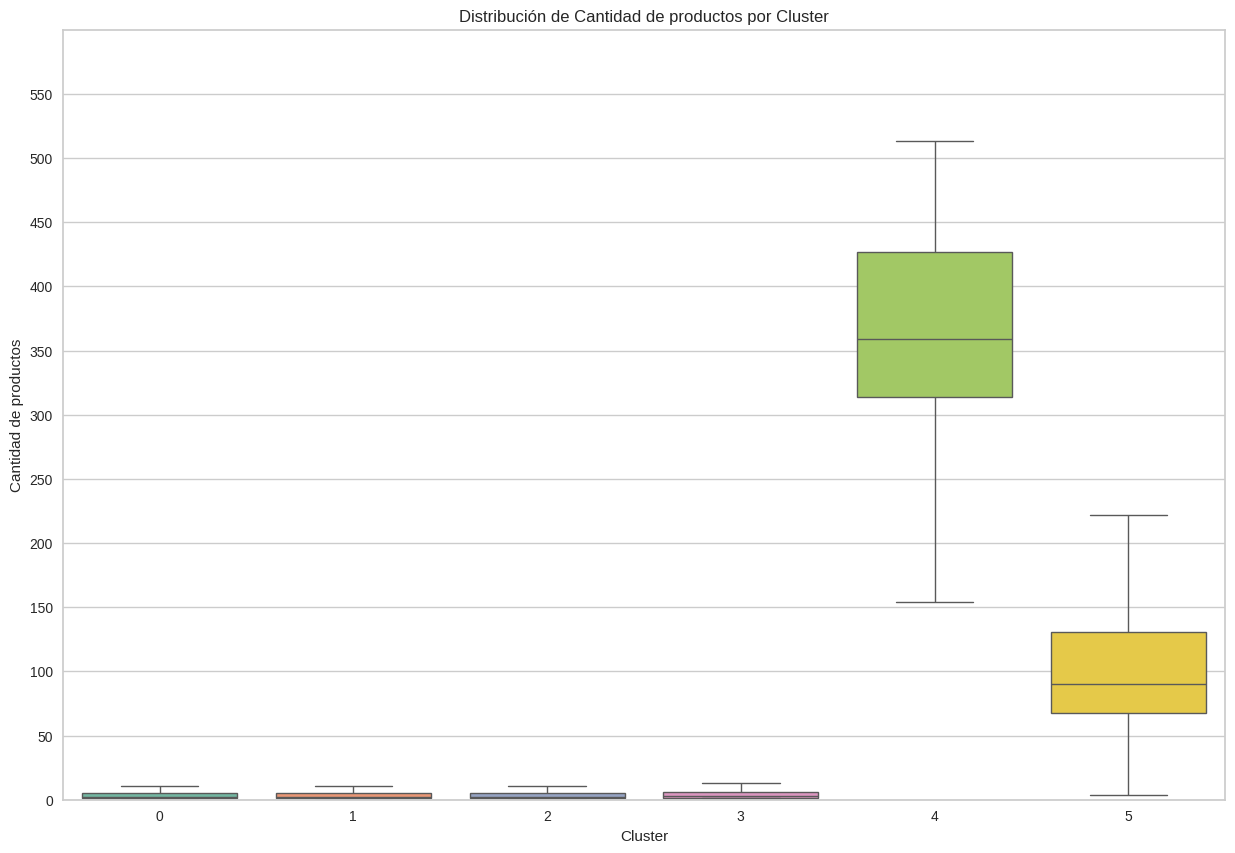

In [ ]:
# Crear el gráfico de boxplot para la variable Cantidad de Productos
palette = sns.color_palette("Set2")
plt.figure(figsize=(15, 10))  # Opcional: ajustar el tamaño del gráfico
sns.boxplot(x='Cluster', y='Cantidad_productos', data=data_grupo, palette=palette, showfliers=False)

plt.ylim(0, 600)
plt.yticks(ticks=np.arange(0, 600, 50))

plt.title('Distribución de Cantidad de productos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de productos')

plt.show()

In [ ]:
# Estadisticas de los 'cluster' para cada variable
resultados_clusters = data_grupo.groupby('Cluster').agg({
    'Cantidad_productos': ['mean', 'std', 'min', 'max', 'median'],
    'Monto_ventas': ['mean', 'std', 'min', 'max', 'median'],
    'Fecha': ['min', 'max']  # Para fechas interesa el rango (mín y máx)
})

print(resultados_clusters)


        Cantidad_productos                             Monto_ventas  \
                      mean         std min  max median         mean   
Cluster                                                               
0                 4.553959    6.262436   1   73    2.0    19.368979   
1                 4.406542    6.210007   1   66    2.0    19.443974   
2                 5.140476    7.439194   1   66    2.0    27.336661   
3                 5.315831    7.734710   1   66    3.0    28.442621   
4               352.473684  135.433201  19  632  359.0  2014.679815   
5               101.472527   54.641947   4  295   90.0   594.890097   

                                                                Fecha  \
                std          min          max       median        min   
Cluster                                                                 
0         30.569179     0.115054   516.741307    10.513488 2022-06-01   
1         28.696098     1.096994   413.269287    10.690505 2022-05-3

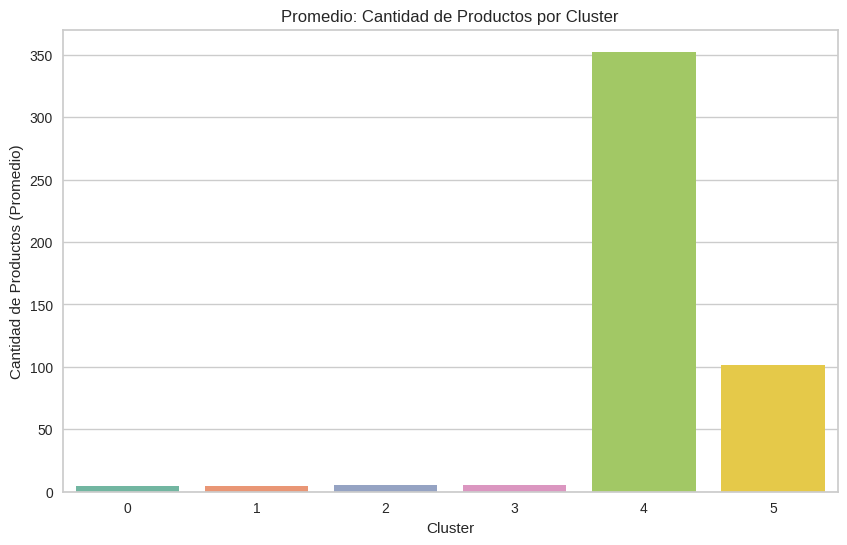

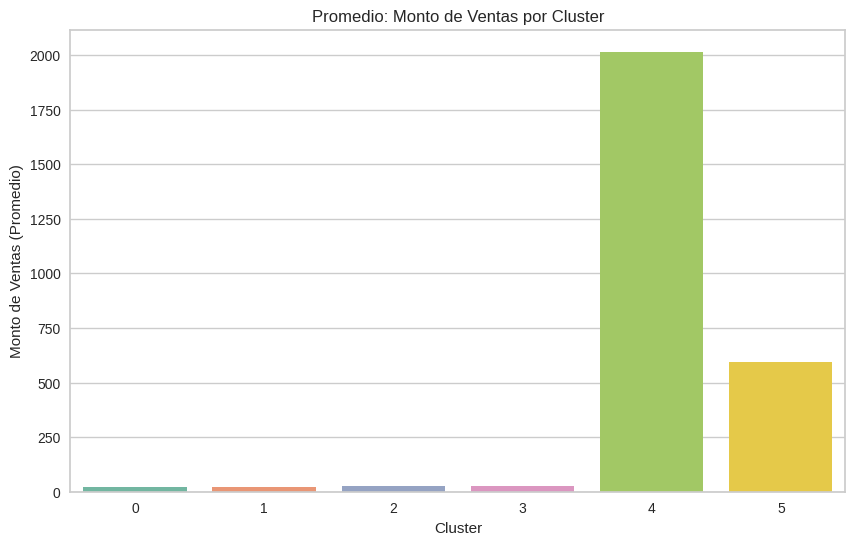

In [ ]:
# Crear un DataFrame con los resultados agrupados por cluster
resultados = data_grupo.groupby('Cluster').agg({
    'Cantidad_productos': ['mean'],
    'Monto_ventas': ['mean']
}).reset_index()

# Renombrar las columnas para facilitar la visualización
resultados.columns = ['cluster', 'cantidad_productos_mean', 'monto_ventas_mean']

palette = sns.color_palette("Set2", n_colors=resultados['cluster'].nunique())

# Gráfico de barras para 'Cantidad_productos'
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='cantidad_productos_mean', data=resultados, palette='Set2')
plt.title('Promedio: Cantidad de Productos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de Productos (Promedio)')
plt.show()

# Gráfico de barras para 'Monto_ventas'
plt.figure(figsize=(10, 6))
sns.barplot(x='cluster', y='monto_ventas_mean', data=resultados, palette='Set2')
plt.title('Promedio: Monto de Ventas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monto de Ventas (Promedio)')
plt.show()


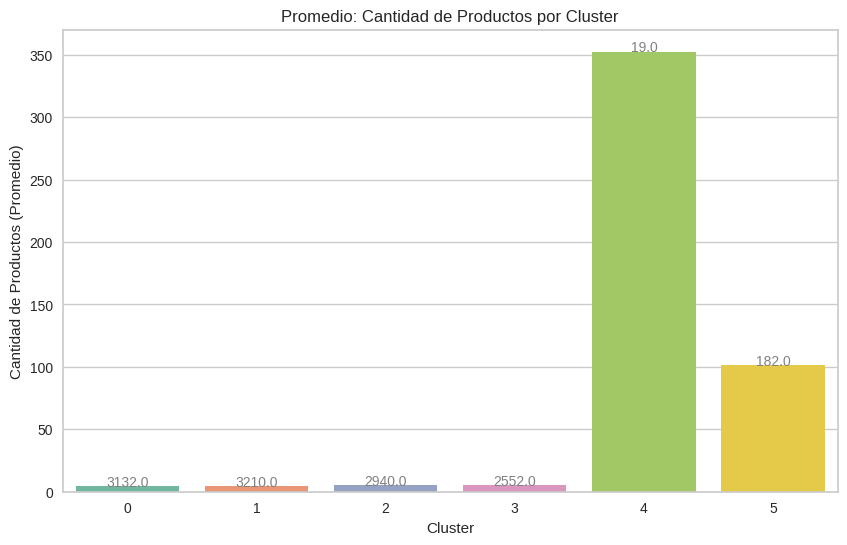

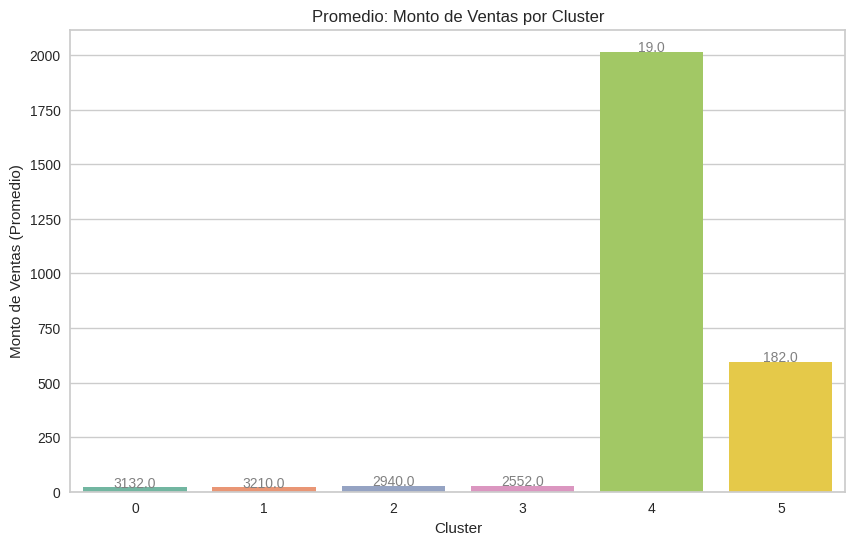

In [ ]:
# Cantidad de filas (clientes) por cluster
cantidad_filas_por_cluster = data_grupo.groupby('Cluster').size().reset_index(name='cantidad_filas')

# Unir los resultados con la cantidad de filas
resultados = data_grupo.groupby('Cluster').agg({
    'Cantidad_productos': ['mean'],
    'Monto_ventas': ['mean']
}).reset_index()

#Renombrar columnas
resultados.columns = ['cluster', 'cantidad_productos_mean', 'monto_ventas_mean']

# Unir la cantidad de filas al DataFrame de resultados
resultados = resultados.merge(cantidad_filas_por_cluster, left_on='cluster', right_on='Cluster')

# Definir la paleta de colores
palette = sns.color_palette("Set2", n_colors=resultados['cluster'].nunique())

# Gráfico de barras para 'Cantidad_productos'
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='cantidad_productos_mean', data=resultados, palette=palette)

# Añadir la cantidad de filas sobre las barras
for i, row in resultados.iterrows():
    ax.text(i, row['cantidad_productos_mean'] + 0.05, f'{row["cantidad_filas"]}', ha='center', color='gray',fontsize=10)

plt.title('Promedio: Cantidad de Productos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cantidad de Productos (Promedio)')
plt.show()

# Gráfico de barras para 'Monto_ventas'
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='monto_ventas_mean', data=resultados, palette=palette)

# Añadir la cantidad de filas sobre las barras
for i, row in resultados.iterrows():
    ax.text(i, row['monto_ventas_mean'] + 0.05, f'{row["cantidad_filas"]}', ha='center', color='gray',fontsize=10)

plt.title('Promedio: Monto de Ventas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monto de Ventas (Promedio)')
plt.show()


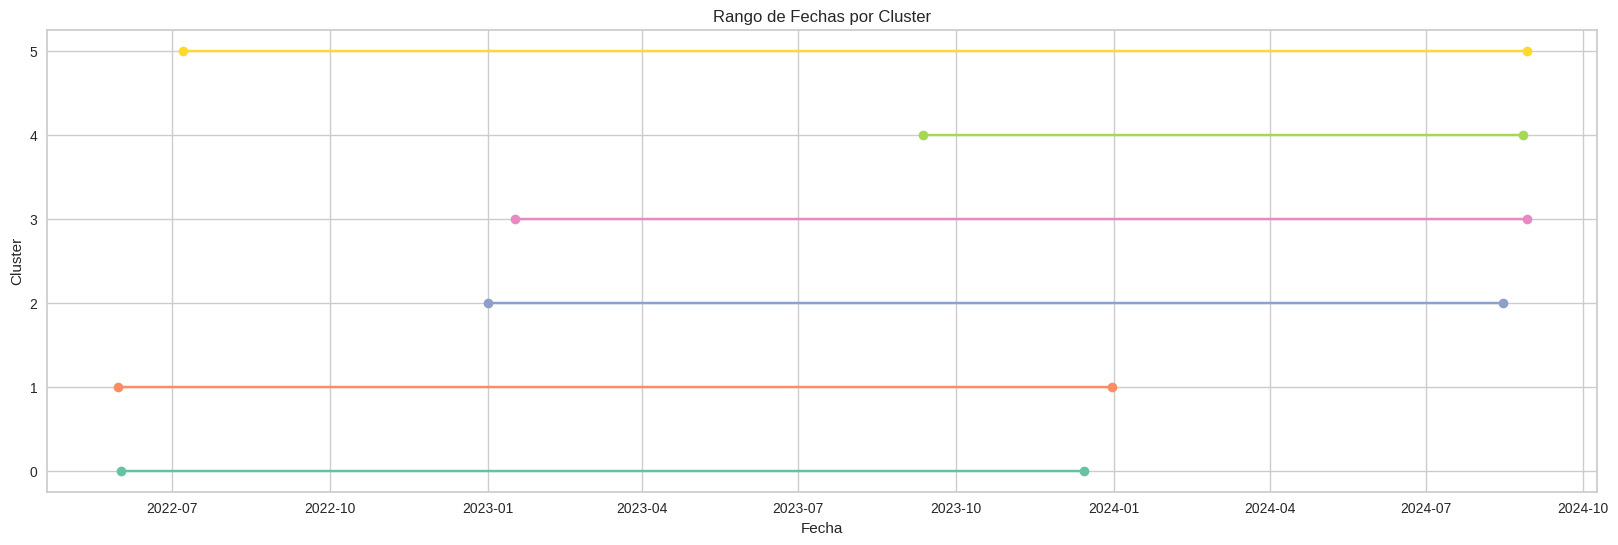

In [ ]:
# Agrupar por cluster y calcular las fechas mínimas y máximas
fechas_cluster = data_grupo.groupby('Cluster').agg({'Fecha': ['min', 'max']}).reset_index()
fechas_cluster.columns = ['cluster', 'fecha_min', 'fecha_max']

palette = sns.color_palette("Set2", n_colors=len(fechas_cluster))

plt.figure(figsize=(20, 6))
for i, row in fechas_cluster.iterrows():
    plt.plot([row['fecha_min'], row['fecha_max']], [row['cluster'], row['cluster']], marker='o', label=f'Cluster {row["cluster"]}', color=palette[i])

plt.xlabel('Fecha')
plt.ylabel('Cluster')

plt.title('Rango de Fechas por Cluster')
plt.xlabel('Fecha')
plt.ylabel('Cluster')
plt.show()


##**2. Modelo DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**


Adecuados para datos con ruido y grupos de formas y densidades variables. No requiere especificar la cantidad de grupos, sino que se basa en parámetros de densidad.


In [ ]:
# Eliminar las columnas 'Cliente' y 'Provincia'
data_reducida = data_grupo.drop(columns=['Cliente', 'Provincia'])

# Chequear columnas numéricas
data_reducida = data_reducida.select_dtypes(include=[np.number])

# Entrenar modelo de clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data_reducida)

# Asegurarse de que se hayan identificado al menos 2 clusters para calcular las métricas
if len(set(clusters)) > 1:
    silhouette = silhouette_score(data_reducida, clusters)
    calinski_harabasz = calinski_harabasz_score(data_reducida, clusters)
    davies_bouldin = davies_bouldin_score(data_reducida, clusters)

    print(f'Silhouette Score: {silhouette}')
    print(f'Calinski-Harabasz Index: {calinski_harabasz}')
    print(f'Davies-Bouldin Index: {davies_bouldin}')
else:
    print("No se han encontrado suficientes clusters para calcular las métricas.")


Silhouette Score: -0.23517442890660245
Calinski-Harabasz Index: 15.043871993987164
Davies-Bouldin Index: 1.7323550483704948


No son buenas métricas, las métricas del modelo Kmeans dieron mejor.

https://medium.com/@nomannayeem/clustering-with-confidence-a-practical-guide-to-data-clustering-in-python-15d82d8a7bfb